In [1]:
from brian2 import *
%matplotlib inline

In [2]:

# Neuron parameters
C_Ax = 5.0 * nF # Capacitance of action-potential compartment
C_Sh = 8.0 * nF # Capacitance of shunt compartment
C_in = 5.0 * nF # Capacitance of P cells

g_c = 55.0 * nS # Coupling conductance
g_l =  5.0 * nS # leak conductance

E_l = -60.0 * mV # Resting potential
E_i = -60.0 * mV # Shunting reversal potential

V_t = -58.0 * mV # Threshold
V_r = -62.0 * mV # Reset

tau_e = 20.0 * ms # Excitatory time-constant.
tau_i = 100.0 * ms # Inhibitory time-constant.

eqs_inA = Equations('''
    dV/dt = (g_l * (E_l - V) + I_ext + timed_input_A(t,i)) / C_in : volt   
    I_ext : amp
    ''')

eqs_inB = Equations('''
    dV/dt = (g_l * (E_l - V) + I_ext + timed_input_B(t,i)) / C_in : volt   
    I_ext : amp
    ''')

# The principal cells and inhibitory neurons are based on the two-compartment model
eqs_2 = Equations('''
    dV/dt = (g_l * (E_l - V) + g_c * (Vs - V)) / C_Ax : volt
    dVs/dt = (g_l * (E_l - Vs) + g_c * (V - Vs) + gi * (E_i - Vs) + Id + I_ext) / C_Sh : volt
    dId/dt = -Id/tau_e : amp
    dgi/dt = -gi/tau_i : siemens
    I_ext : amp
    ''')


In [43]:
# Circuit Parameters

N_inA = 10
N_inB = 10
N_2 = 20
N_mult = 8
N_inh = 8

# Neuron Groups
G_inA = NeuronGroup(N_inA, model=eqs_inA, threshold='V>V_t', reset='V=V_r', refractory=0*ms)
G_inB = NeuronGroup(N_inB, model=eqs_inB, threshold='V>V_t', reset='V=V_r', refractory=0*ms)
G_2 = NeuronGroup(N_2, model=eqs_2, threshold='V>V_t', reset='V=V_r', refractory=0*ms)
G_mult = NeuronGroup(N_mult, model=eqs_2, threshold='V>V_t', reset='V=V_r', refractory=0*ms)
G_inh = NeuronGroup(N_inh, model=eqs_2, threshold='V>V_t', reset='V=V_r', refractory=0*ms)

# Synapses
S_inA_2 = Synapses(G_inA, G_2, 'w : amp', pre='Id_post += w')
S_inB_2 = Synapses(G_inB, G_2, 'w : amp', pre='Id_post += w')
S_2_2 = Synapses(G_2, G_2, 'w : amp', pre='Id_post += w')
S_inh_2 = Synapses(G_inh, G_2, 'w : amp', pre='Id_post += w')
# These are the shunting synapses
S_mult_2 = Synapses(G_mult, G_2, 'w : siemens', pre='gi_post += w')

S_inA_inh = Synapses(G_inA, G_inh, 'w : amp', pre='Id_post += w')
S_inB_inh = Synapses(G_inB, G_inh, 'w : amp', pre='Id_post += w')
S_2_inh = Synapses(G_2, G_inh, 'w : amp', pre='Id_post += w')

S_inA_mult = Synapses(G_inA, G_mult, 'w : amp', pre='Id_post += w')
S_inB_mult = Synapses(G_inB, G_mult, 'w : amp', pre='Id_post += w')
S_2_mult = Synapses(G_2, G_mult, 'w : amp', pre='Id_post += w')

# Monitors
SpM_inA = SpikeMonitor(G_inA)
SpM_inB = SpikeMonitor(G_inB)
SpM_2 = SpikeMonitor(G_2)
SpM_inh = SpikeMonitor(G_inh)
SpM_mult = SpikeMonitor(G_mult)

StM_2 = StateMonitor(G_2, True, record=True)
StM_mult = StateMonitor(G_mult, True, record=True)
StM_inh = StateMonitor(G_inh, True, record=True)

# Set the initial conditions and parameters

G_inA.V = E_l * ones(N_inA)
G_inB.V = E_l * ones(N_inB)

G_2.V = E_l * ones(N_2)
G_2.Vs = E_l * ones(N_2)
G_inh.V = E_l * ones(N_inh)
G_inh.Vs = E_l * ones(N_inh)
G_mult.V = E_l * ones(N_mult)
G_mult.Vs = E_l * ones(N_mult)

# give the input cells random current
steps = 4
step_dt = 1.0 * second

timed_input_A = TimedArray(np.random.rand(steps, N_inA) * nA, dt=step_dt)# The input cells are just integrate and fire neurons
timed_input_B = TimedArray(np.random.rand(steps, N_inB) * nA, dt=step_dt)# The input cells are just integrate and fire neurons
#G_inA.I_ext = 'timed_inputA(t,i)'
#G_inB.I_ext = 'sin(4 * pi * t / second) * nA'

#G_inA.I_ext=np.random.rand(N_inA) * nA
#G_inB.I_ext=np.random.rand(N_inB) * nA

#G_inA.run_regularly('''I_ext=np.random.rand() * nA''',dt=0.5*second)
#G_inB.run_regularly('''I_ext=np.random.rand() * nA''',dt=0.5*second)

#G_inA.I_ext = np.random.rand(N_inA) * nA
#G_inB.I_ext = TimedArray(np.random.rand(N_inB, steps) * nA, dt=step_dt)


inA_2_weight = np.random.rand(N_inA, N_2)
inB_2_weight = np.random.rand(N_inB, N_2)
inA_2_weight = 2.0 * inA_2_weight / tile(sum(inA_2_weight, 0), (inA_2_weight.shape[0], 1)) * nA
inB_2_weight = 2.0 * inB_2_weight / tile(sum(inB_2_weight, 0), (inB_2_weight.shape[0], 1)) * nA

inA_inh_weight = np.random.rand(N_inA, N_inh)
inB_inh_weight = np.random.rand(N_inB, N_inh)
inA_inh_weight = 1.0 * inA_inh_weight / tile(sum(inA_inh_weight, 0), (inA_inh_weight.shape[0], 1)) * nA
inB_inh_weight = 1.0 * inB_inh_weight / tile(sum(inB_inh_weight, 0), (inB_inh_weight.shape[0], 1)) * nA


inh_2_weight = -0.5 * np.ones((N_inh, N_2)) * nA

mult_2_weight = 0.2 * np.ones((N_mult, N_2)) * nS

g2_inh_weight = 0.2 * np.ones((N_2, N_inh)) * nA
g2_mult_weight = 0.2 * np.ones((N_2, N_mult)) * nA

S_inA_2.connect(True)
S_inA_2.w = inA_2_weight.flatten()
S_inB_2.connect(True)
S_inB_2.w = inB_2_weight.flatten()
S_inA_inh.connect(True)
S_inA_inh.w = inA_inh_weight.flatten()
S_inB_inh.connect(True)
S_inB_inh.w = inB_inh_weight.flatten()
S_inh_2.connect(True)
S_inh_2.w = inh_2_weight.flatten()
S_mult_2.connect(True)
S_mult_2.w = mult_2_weight.flatten()
S_2_inh.connect(True)
S_2_inh.w = g2_inh_weight.flatten()
S_2_mult.connect(True)
S_2_mult.w = g2_mult_weight.flatten()

# create the network
gain_net = Network()

gain_net.add(G_inA)
gain_net.add(G_inB)
gain_net.add(G_2)
gain_net.add(G_inh)
gain_net.add(G_mult)

gain_net.add(S_inA_2)
gain_net.add(S_inB_2)
gain_net.add(S_2_2)
gain_net.add(S_inh_2)
gain_net.add(S_mult_2)

gain_net.add(S_inA_inh)
gain_net.add(S_inB_inh)
gain_net.add(S_2_inh)
gain_net.add(S_inA_mult)
gain_net.add(S_inB_mult)
gain_net.add(S_2_mult)

gain_net.add(SpM_inA)
gain_net.add(SpM_inB)
gain_net.add(SpM_2)
gain_net.add(SpM_inh)
gain_net.add(SpM_mult)
gain_net.add(StM_2)
gain_net.add(StM_inh)
gain_net.add(StM_mult)

gain_net.store('init')

WARNING  brian2.groups.group.Group.resolve.resolution_conflict: Variable i is present in the namespace but is also an internal variable of neurongroup_10, the internal variable will be used.
WARNING  brian2.groups.group.Group.resolve.resolution_conflict: Variable i is present in the namespace but is also an internal variable of neurongroup_11, the internal variable will be used.
WARNING  brian2.synapses.synapses.no_synapses: Synapses object 'synapses_24' does not have any synapses. Did you forget a 'connect'?
WARNING  brian2.synapses.synapses.no_synapses: Synapses object 'synapses_30' does not have any synapses. Did you forget a 'connect'?
WARNING  brian2.synapses.synapses.no_synapses: Synapses object 'synapses_31' does not have any synapses. Did you forget a 'connect'?


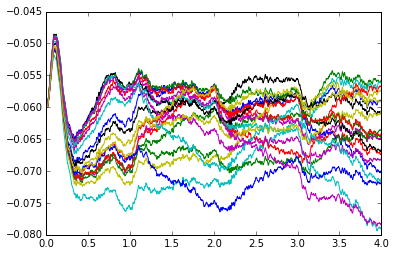

In [44]:
# Simulation parameters
defaultclock.dt = 0.1 * ms
run_time = 4000 * ms


gain_net.restore('init')
gain_net.run(run_time)

figure()
plot(StM_2.t / second, StM_2.Vs.T)


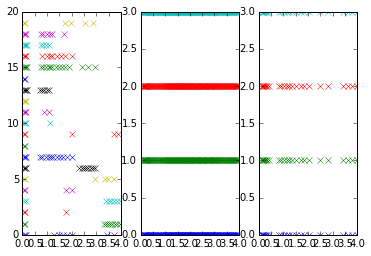

In [45]:
spike_trains_2 = SpM_2.spike_trains()
spike_trains_inh = SpM_inh.spike_trains()
spike_trains_mult = SpM_mult.spike_trains()

subplot(131)
for i in range(N_2):
    plot(spike_trains_2[i], i * ones(len(spike_trains_2[i])), 'x')

subplot(132)
for i in range(N_inh):
    plot(spike_trains_inh[i], i * ones(len(spike_trains_inh[i])), 'x')

subplot(133)
for i in range(N_mult):
    plot(spike_trains_mult[i], i * ones(len(spike_trains_mult[i])), 'x')


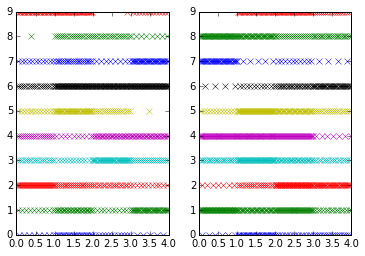

In [46]:
spike_trains_inA = SpM_inA.spike_trains()
spike_trains_inB = SpM_inB.spike_trains()


subplot(121)
for i in range(N_inA):
    plot(spike_trains_inA[i], i * ones(len(spike_trains_inA[i])), 'x')

subplot(122)
for i in range(N_inB):
    plot(spike_trains_inB[i], i * ones(len(spike_trains_inB[i])), 'x')


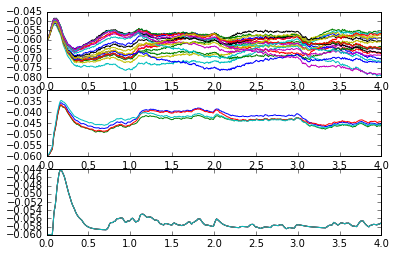

In [47]:
figure()
subplot(311)
plot(StM_2.t / second, StM_2.Vs.T)
subplot(312)
plot(StM_inh.t / second, StM_inh.Vs.T)
subplot(313)
plot(StM_mult.t / second, StM_mult.Vs.T)


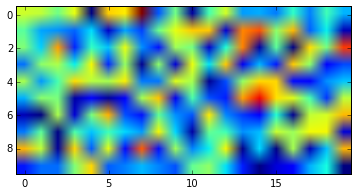

In [34]:
imshow(np.array(inA_2_weight))

In [21]:
inA_2_weight / tile(sum(inA_2_weight, 0), (inA_2_weight.shape[0], 1))


array([[ 0.12263678,  0.00915478,  0.08880336,  0.00774954,  0.18184831,
         0.1221086 ,  0.04395616,  0.03466017,  0.20826865,  0.02012356,
         0.0620753 ,  0.00386774,  0.19580327,  0.10725488,  0.26041087,
         0.10581181,  0.20438643,  0.17140282,  0.02535641,  0.04039539],
       [ 0.12328873,  0.16916891,  0.13520828,  0.22076303,  0.18715887,
         0.04191434,  0.16147328,  0.10545281,  0.18553381,  0.18984669,
         0.03210767,  0.14807118,  0.19237356,  0.07110162,  0.12002086,
         0.12485099,  0.17204919,  0.0867895 ,  0.118793  ,  0.04835617],
       [ 0.0246215 ,  0.18969791,  0.18585085,  0.04745768,  0.07975676,
         0.08448335,  0.02514831,  0.16331863,  0.06050796,  0.09993471,
         0.02337256,  0.17495845,  0.22855387,  0.02890147,  0.00656368,
         0.1391093 ,  0.02557247,  0.13736067,  0.17748931,  0.03018777],
       [ 0.0396076 ,  0.02446111,  0.16826953,  0.13328739,  0.06664856,
         0.12786533,  0.12529617,  0.12239085,  